<a href="https://colab.research.google.com/github/Shallom12/Autonomous-driving-of-Chungnam-Human-Resources-Development-Institute/blob/main/%F0%9F%9A%97_%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89_AI%EB%A5%BC_%EC%9C%84%ED%95%9C_ImageNet_%EA%B0%9D%EC%B2%B4_%EB%B6%84%EB%A5%98%EA%B8%B0(07.16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚗 자율주행 AI를 위한 ImageNet 객체 분류기 해설
이 코드는 PyTorch와 torchvision 라이브러리를 활용하여 ImageNet 데이터셋으로 사전 훈련된 컨볼루션 신경망(CNN) 모델을 이용한 이미지 분류 시스템을 구현합니다. 자율주행 시스템에서 주변 환경을 정확하게 인식하는 것은 필수적이며, 이 분류기는 도로 위의 다양한 객체(차량, 보행자, 표지판 등)를 식별하는 기본 구성 요소로 활용될 수 있습니다.

📦 필요한 라이브러리 설치 및 임포트

In [1]:
# 필요한 라이브러리 설치 및 임포트
import torch # PyTorch 딥러닝 프레임워크
import torch.nn as nn # 신경망 모듈
import torchvision.transforms as transforms # 이미지 전처리 유틸리티
import torchvision.models as models # 사전 훈련된 모델
from PIL import Image # Pillow 이미지 처리 라이브러리
import numpy as np # 수치 계산 라이브러리
import matplotlib.pyplot as plt # 그래프 및 시각화 라이브러리
import requests # HTTP 요청 라이브러리 (ImageNet 라벨 다운로드용)
import json # JSON 데이터 처리 (선택적)
from io import BytesIO # 바이트 스트림 처리
import cv2 # OpenCV 라이브러리 (이 코드에서는 직접 사용되지 않지만 이미지 처리 관련)

# 라이브러리 로드 확인 및 PyTorch, CUDA 정보 출력
print("✅ 라이브러리 로드 완료!")
print(f"🔥 PyTorch 버전: {torch.__version__}")
print(f"💻 CUDA 사용 가능: {torch.cuda.is_available()}")

✅ 라이브러리 로드 완료!
🔥 PyTorch 버전: 2.6.0+cu124
💻 CUDA 사용 가능: True


이 섹션에서는 파이썬에서 필요한 모든 라이브러리를 가져옵니다. PyTorch는 딥러닝 모델을 구축하고 실행하는 핵심 프레임워크이며, torchvision은 이미지 데이터셋과 모델을 제공합니다. **PIL (Pillow)**은 이미지를 로드하고 조작하는 데 사용되며, Matplotlib은 결과를 시각화하는 데 중요합니다. requests는 ImageNet 클래스 라벨 파일을 웹에서 가져오는 데 활용됩니다.

🧠 ImageNet 1000개 클래스 분류기 클래스 정의
이 ImageNetClassifier 클래스는 ImageNet 데이터셋으로 사전 훈련된 다양한 모델을 로드하고, 이미지를 전처리하여 예측을 수행하며, 그 결과를 시각화하는 모든 기능을 캡슐화합니다.



In [2]:
# =============================================================================
# ImageNet 1000개 클래스 분류기 클래스
# =============================================================================
class ImageNetClassifier:
    """
    ImageNet 사전 훈련된 모델을 사용한 1000개 클래스 분류기.
    주어진 이미지에 대해 객체 인식을 수행하고 그 결과를 시각화합니다.
    """

    def __init__(self, model_name='resnet50'):
        """
        분류기 초기화. 지정된 모델을 로드하고 디바이스(GPU/CPU)를 설정합니다.
        Args:
            model_name (str): 사용할 사전 훈련된 모델의 이름 (예: 'resnet50', 'vgg16').
        """
        print(f"🧠 {model_name} 모델 로딩 중...")
        # CUDA(GPU) 사용 가능 여부 확인 및 디바이스 설정
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"💻 사용 디바이스: {self.device}")

        # 선택된 모델 로드 및 평가 모드 설정 (추론 시 드롭아웃 등 비활성화)
        self.model = self.load_model(model_name)
        self.model.eval()  # 모델을 평가 모드로 설정

        # ImageNet 1000개 클래스 라벨 로드
        self.class_labels = self.load_imagenet_labels()

        # 이미지 전처리 파이프라인 설정
        # 모델 입력에 맞게 이미지 크기 조정, 중앙 자르기, Tensor 변환 및 정규화 수행
        self.transform = transforms.Compose([
            transforms.Resize(256),       # 이미지 짧은 변을 256픽셀로 조정
            transforms.CenterCrop(224),   # 중앙 224x224 픽셀 영역 자르기 (모델 입력 크기)
            transforms.ToTensor(),        # PIL Image를 PyTorch Tensor로 변환 (0-1 범위)
            transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet 평균으로 정규화
                                 std=[0.229, 0.224, 0.225])   # ImageNet 표준편차로 정규화
        ])

        print(f"✅ {model_name} 모델 준비 완료!")
        print(f"📊 분류 가능한 클래스: {len(self.class_labels)}개")

    def load_model(self, model_name):
        """
        사전 훈련된 모델을 로드합니다. 지원되지 않는 모델 이름일 경우 ResNet50을 기본으로 사용합니다.
        Args:
            model_name (str): 로드할 모델의 이름.
        Returns:
            torch.nn.Module: 로드된 사전 훈련된 모델.
        """
        # 지원하는 모델 목록 정의
        models_dict = {
            'resnet50': models.resnet50(pretrained=True),
            'resnet101': models.resnet101(pretrained=True),
            'vgg16': models.vgg16(pretrained=True),
            'vgg19': models.vgg19(pretrained=True),
            'densenet121': models.densenet121(pretrained=True),
            'efficientnet_b0': models.efficientnet_b0(pretrained=True),
            'mobilenet_v2': models.mobilenet_v2(pretrained=True),
            'alexnet': models.alexnet(pretrained=True),
            'inception_v3': models.inception_v3(pretrained=True)
        }

        # 요청된 모델 이름이 목록에 없는 경우 기본 모델 사용 경고
        if model_name not in models_dict:
            print(f"⚠️ {model_name} 모델을 찾을 수 없습니다. ResNet50을 사용합니다.")
            model_name = 'resnet50'

        # 모델을 선택된 디바이스로 이동
        model = models_dict[model_name]
        return model.to(self.device)

    def load_imagenet_labels(self):
        """
        ImageNet 1000개 클래스의 라벨을 웹에서 다운로드하거나, 실패 시 기본 라벨을 반환합니다.
        Returns:
            list: ImageNet 클래스 이름 문자열 리스트.
        """
        try:
            # GitHub에서 ImageNet 클래스 라벨 파일 다운로드
            url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
            response = requests.get(url)
            labels = response.text.strip().split('\n')
            print(f"📋 ImageNet 라벨 로드 완료: {len(labels)}개")
            return labels
        except:
            # 다운로드 실패 시 대체 라벨 생성
            print("⚠️ 온라인 라벨 로드 실패. 기본 라벨을 사용합니다.")
            return [f"class_{i}" for i in range(1000)] # 대체 라벨

    def load_image(self, image_source):
        """
        이미지를 파일 경로 또는 URL에서 로드하거나, PIL Image 객체를 처리합니다.
        Args:
            image_source (str or PIL.Image.Image): 이미지 파일 경로, URL 또는 PIL Image 객체.
        Returns:
            PIL.Image.Image: 로드된 PIL Image 객체 (RGB), 로드 실패 시 None.
        """
        try:
            if isinstance(image_source, str):
                if image_source.startswith('http'):
                    # URL에서 이미지 다운로드 및 로드
                    response = requests.get(image_source)
                    image = Image.open(BytesIO(response.content)).convert('RGB')
                else:
                    # 로컬 파일 경로에서 이미지 로드
                    image = Image.open(image_source).convert('RGB')
            else:
                # 이미 PIL Image 객체인 경우 RGB로 변환
                image = image_source.convert('RGB')
            return image
        except Exception as e:
            print(f"❌ 이미지 로드 실패: {e}")
            return None

    def preprocess_image(self, image):
        """
        분류를 위해 이미지를 모델 입력 형식에 맞게 전처리합니다.
        Args:
            image (PIL.Image.Image): 전처리할 PIL Image 객체.
        Returns:
            torch.Tensor: 전처리된 이미지 Tensor, 입력 이미지가 None인 경우 None.
        """
        if image is None:
            return None

        # PIL Image를 정의된 transform 파이프라인을 통해 Tensor로 변환 후 배치 차원 추가
        tensor = self.transform(image).unsqueeze(0)  # [C, H, W] -> [1, C, H, W] (배치 크기 1)
        return tensor.to(self.device)

    def predict(self, image_source, top_k=5):
        """
        주어진 이미지에 대해 ImageNet 클래스 분류 예측을 수행합니다.
        Args:
            image_source (str or PIL.Image.Image): 예측할 이미지의 소스.
            top_k (int): 상위 몇 개의 예측 결과를 반환할지 지정.
        Returns:
            dict: 원본 이미지, 예측 결과 리스트, 모델 정보 등을 포함하는 딕셔너리.
                  이미지 로드 또는 전처리 실패 시 None.
        """
        print(f"🔍 이미지 분석 중...")

        # 이미지 로드
        image = self.load_image(image_source)
        if image is None:
            return None

        original_image = image.copy() # 시각화를 위해 원본 이미지 복사

        # 이미지 전처리
        input_tensor = self.preprocess_image(image)
        if input_tensor is None:
            return None

        # 모델을 이용한 예측 (gradient 계산 비활성화로 메모리 및 속도 최적화)
        with torch.no_grad():
            outputs = self.model(input_tensor)
            # Softmax를 적용하여 각 클래스에 대한 확률 분포 계산
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        # 상위 K개 예측 결과 추출
        top_prob, top_indices = torch.topk(probabilities, top_k)

        results = []
        for i in range(top_k):
            class_idx = top_indices[i].item() # 클래스 인덱스
            prob = top_prob[i].item()         # 확률 값
            class_name = self.class_labels[class_idx] # 클래스 이름
            results.append({
                'rank': i + 1,
                'class_index': class_idx,
                'class_name': class_name,
                'probability': prob,
                'percentage': prob * 100 # 백분율로 변환
            })

        return {
            'original_image': original_image,
            'predictions': results,
            'model_info': {
                'model_name': self.model.__class__.__name__, # 사용된 모델의 클래스 이름
                'device': str(self.device), # 사용된 디바이스
                'total_classes': len(self.class_labels) # 총 분류 클래스 수
            }
        }

    def visualize_results(self, results, show_top_k=5):
        """
        분류 결과를 시각화합니다. 원본 이미지와 예측 확률 막대 그래프를 표시합니다.
        Args:
            results (dict): predict() 메서드에서 반환된 결과 딕셔너리.
            show_top_k (int): 시각화에 표시할 상위 예측 개수.
        """
        if results is None:
            print("❌ 결과가 없습니다.")
            return

        # 콘솔에 예측 결과 출력
        print(f"\n🎯 ImageNet 분류 결과 (Top {show_top_k}):")
        print("=" * 60)

        predictions = results['predictions'][:show_top_k]

        for pred in predictions:
            print(f"{pred['rank']}. {pred['class_name']:<30} {pred['percentage']:.2f}%")
        print("=" * 60)

        # Matplotlib을 사용하여 이미지와 그래프 시각화
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # 원본 이미지 표시
        ax1.imshow(results['original_image'])
        ax1.set_title('Original Image', fontsize=14, fontweight='bold')
        ax1.axis('off') # 축 제거

        # 예측 결과 막대 그래프 생성
        class_names = [pred['class_name'][:20] for pred in predictions]  # 라벨 길이를 20자로 제한
        probabilities = [pred['percentage'] for pred in predictions]
        colors = plt.cm.viridis(np.linspace(0, 1, len(predictions))) # 색상 팔레트

        bars = ax2.barh(range(len(predictions)), probabilities, color=colors)
        ax2.set_yticks(range(len(predictions)))
        ax2.set_yticklabels(class_names)
        ax2.set_xlabel('Confidence (%)')
        ax2.set_title(f'Top {show_top_k} Predictions', fontsize=14, fontweight='bold')
        ax2.invert_yaxis()  # 가장 높은 확률이 맨 위에 오도록 Y축 반전

        # 막대 위에 퍼센트 값 텍스트 추가
        for i, (bar, prob) in enumerate(zip(bars, probabilities)):
            ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                     f'{prob:.1f}%', va='center', fontweight='bold')

        # 전체 그래프 제목 (가장 높은 예측 결과 표시)
        best_prediction = predictions[0]
        plt.suptitle(f'🏆 Best Prediction: {best_prediction["class_name"]} ({best_prediction["percentage"]:.1f}%)',
                     fontsize=16, fontweight='bold')

        plt.tight_layout() # 레이아웃 자동 조정
        plt.show()

        # 모델 정보 출력
        model_info = results['model_info']
        print(f"\n📊 모델 정보:")
        print(f"  🧠 모델: {model_info['model_name']}")
        print(f"  💻 디바이스: {model_info['device']}")
        print(f"  📋 총 클래스 수: {model_info['total_classes']}")

    def compare_models(self, image_source, model_names=['resnet50', 'vgg16', 'efficientnet_b0']):
        """
        하나의 이미지에 대해 여러 ImageNet 모델의 성능을 비교합니다.
        각 모델의 최고 예측 결과와 신뢰도를 보여줍니다.
        Args:
            image_source (str or PIL.Image.Image): 비교할 이미지의 소스.
            model_names (list): 비교할 모델 이름 리스트.
        Returns:
            list: 각 모델의 비교 결과를 담은 딕셔너리 리스트.
        """
        print(f"🔄 다중 모델 비교 시작...")

        original_model = self.model # 현재 로드된 모델 저장
        original_name = original_model.__class__.__name__

        results_comparison = []

        for model_name in model_names:
            print(f"\n🧠 {model_name} 모델로 예측 중...")

            # 현재 분류기의 모델을 변경하여 예측 수행
            self.model = self.load_model(model_name)
            self.model.eval()

            # 이미지 예측 및 결과 저장
            result = self.predict(image_source, top_k=3) # 상위 3개 예측만 가져옴
            if result:
                best_pred = result['predictions'][0]
                results_comparison.append({
                    'model_name': model_name,
                    'best_class': best_pred['class_name'],
                    'confidence': best_pred['percentage'],
                    'top3': result['predictions'] # 상위 3개 예측 전체 저장
                })

        # 비교 후 원래 모델로 복원
        self.model = original_model

        # 비교 결과 시각화
        if results_comparison:
            self.visualize_model_comparison(results_comparison, image_source)

        return results_comparison

    def visualize_model_comparison(self, results_comparison, image_source):
        """
        여러 모델의 비교 결과를 시각화합니다.
        원본 이미지, 모델별 신뢰도 막대 그래프, 상세 비교 테이블, Top 3 예측을 표시합니다.
        Args:
            results_comparison (list): compare_models()에서 반환된 비교 결과 리스트.
            image_source (str or PIL.Image.Image): 비교에 사용된 이미지의 소스.
        """
        # 이미지 로드 (시각화용)
        image = self.load_image(image_source)

        # 2x2 서브플롯 구성
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # [0,0] 서브플롯: 원본 이미지
        axes[0, 0].imshow(image)
        axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')

        # [0,1] 서브플롯: 모델별 Top 1 예측 신뢰도 비교 막대 그래프
        model_names = [result['model_name'] for result in results_comparison]
        confidences = [result['confidence'] for result in results_comparison]
        predictions = [result['best_class'][:15] for result in results_comparison] # 라벨 단축

        colors = ['red', 'blue', 'green', 'orange', 'purple'][:len(model_names)] # 모델별 색상

        bars = axes[0, 1].bar(model_names, confidences, color=colors, alpha=0.7)
        axes[0, 1].set_title('Model Confidence Comparison', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('Confidence (%)')
        axes[0, 1].tick_params(axis='x', rotation=45) # x축 라벨 회전

        # 막대 위에 예측 클래스와 확률 텍스트 추가
        for bar, pred, conf in zip(bars, predictions, confidences):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                            f'{pred}\n{conf:.1f}%', ha='center', va='bottom', fontsize=10)

        # [1,0] 서브플롯: 상세 비교 테이블
        axes[1, 0].axis('off') # 축 비활성화
        table_data = []
        for result in results_comparison:
            row = [result['model_name'], result['best_class'][:20], f"{result['confidence']:.1f}%"]
            table_data.append(row)

        table = axes[1, 0].table(cellText=table_data,
                                 colLabels=['Model', 'Best Prediction', 'Confidence'],
                                 cellLoc='center', # 셀 내용 중앙 정렬
                                 loc='center') # 테이블 위치 중앙
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5) # 테이블 크기 조정
        axes[1, 0].set_title('Detailed Comparison', fontsize=14, fontweight='bold')

        # [1,1] 서브플롯: 모델별 Top 3 예측 텍스트
        axes[1, 1].axis('off') # 축 비활성화
        y_pos = 0.9 # 시작 y 위치
        for result in results_comparison:
            axes[1, 1].text(0.05, y_pos, f"🧠 {result['model_name']}:", fontweight='bold', fontsize=12)
            y_pos -= 0.08
            for i, pred in enumerate(result['top3']):
                axes[1, 1].text(0.1, y_pos, f"{i+1}. {pred['class_name'][:25]} ({pred['percentage']:.1f}%)",
                                fontsize=10)
                y_pos -= 0.06
            y_pos -= 0.02 # 모델 간 간격

        axes[1, 1].set_xlim(0, 1) # x축 범위
        axes[1, 1].set_ylim(0, 1) # y축 범위
        axes[1, 1].set_title('Top 3 Predictions per Model', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show() # 모든 서브플롯 표시

ImageNetClassifier 클래스는 다음과 같은 주요 기능을 수행합니다:

초기화 (__init__): 사용할 딥러닝 모델(예: ResNet50)을 지정하고, GPU 또는 CPU 사용 여부를 확인하며, ImageNet 1000개 클래스 라벨을 로드하고, 이미지 전처리(크기 조정, 자르기, 정규화)를 위한 파이프라인을 설정합니다.

모델 로드 (load_model): torchvision.models에서 사전 훈련된 모델을 로드합니다. ResNet, VGG, DenseNet 등 다양한 모델을 지원하며, 없는 모델은 ResNet50으로 대체됩니다.

라벨 로드 (load_imagenet_labels): ImageNet 클래스 이름을 웹에서 가져오거나, 네트워크 문제 시 기본 라벨을 사용합니다.

이미지 로드 (load_image): 로컬 파일 경로, URL 또는 PIL Image 객체로부터 이미지를 로드하여 PIL.Image 형식으로 변환합니다.

이미지 전처리 (preprocess_image): 로드된 이미지를 딥러닝 모델의 입력 형식에 맞게 변환합니다. 이 과정은 모델이 학습한 데이터와 동일한 형식으로 입력 데이터를 준비하는 데 필수적입니다.

예측 (predict): 전처리된 이미지를 모델에 입력하여 각 클래스에 대한 확률을 예측하고, 상위 K개의 결과를 반환합니다.

결과 시각화 (visualize_results): 원본 이미지와 함께 예측된 상위 클래스들의 이름과 확률을 막대 그래프로 시각적으로 보여줍니다. 이는 분류 결과의 직관적인 이해를 돕습니다.

모델 비교 (compare_models, visualize_model_comparison): 여러 모델(예: ResNet50, VGG16, EfficientNet)을 사용하여 동일한 이미지를 분류하고, 각 모델의 성능(가장 높은 예측 클래스 및 신뢰도)을 비교하고 시각화합니다. 자율주행 시스템 개발 시 특정 환경에 최적화된 모델을 선택하는 데 유용합니다.

🚀 실행 함수들
다음 함수들은 Google Colab 환경에서 사용자가 쉽게 분류기를 실행할 수 있도록 고안되었습니다.


In [3]:
# =============================================================================
# 실행 함수들
# =============================================================================

def classify_uploaded_image():
    """
    사용자가 파일을 업로드한 후 ImageNet 분류를 수행합니다.
    단일 이미지에 대한 객체 인식을 진행하고 그 결과를 시각화합니다.
    Returns:
        dict: 분류 결과 딕셔너리, 실패 시 None.
    """
    print("🚀 ImageNet 1000개 클래스 분류기 시작!")
    print("=" * 60)

    print("📁 이미지를 업로드해주세요...")
    print("🎯 1000개 클래스 중에서 가장 유사한 객체를 찾아드립니다!")

    # Google Colab 파일 업로드 위젯 사용
    from google.colab import files
    uploaded = files.upload() # 파일 업로드 대기

    if not uploaded:
        print("❌ 파일이 업로드되지 않았습니다!")
        return None

    filename = list(uploaded.keys())[0] # 업로드된 첫 번째 파일 이름 가져오기
    print(f"📷 업로드된 파일: {filename}")

    try:
        # ResNet50 모델을 사용하여 분류기 인스턴스 생성
        classifier = ImageNetClassifier(model_name='resnet50')

        # 업로드된 이미지에 대한 예측 수행 (상위 10개 결과 요청)
        results = classifier.predict(filename, top_k=10)

        # 상위 5개 예측 결과 시각화
        classifier.visualize_results(results, show_top_k=5)

        print("\n✅ ImageNet 분류 완료!")
        return results

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

def compare_multiple_models():
    """
    사용자가 파일을 업로드한 후 여러 ImageNet 모델(ResNet50, VGG16, EfficientNet_B0, MobileNet_V2)을
    동일한 이미지에 대해 비교하고 결과를 시각화합니다.
    Returns:
        list: 모델 비교 결과 리스트, 실패 시 None.
    """
    print("🔄 다중 모델 성능 비교!")
    print("=" * 60)

    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("❌ 파일이 업로드되지 않았습니다!")
        return None

    filename = list(uploaded.keys())[0]
    print(f"📷 업로드된 파일: {filename}")

    try:
        # 기본 ResNet50 모델로 분류기 인스턴스 생성 (비교 시 내부적으로 모델 변경)
        classifier = ImageNetClassifier()

        # 비교할 모델 목록 정의
        models_to_compare = ['resnet50', 'vgg16', 'efficientnet_b0', 'mobilenet_v2']
        # 지정된 모델들을 사용하여 이미지 비교 실행
        comparison_results = classifier.compare_models(filename, models_to_compare)

        print("\n✅ 다중 모델 비교 완료!")
        return comparison_results

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

def batch_classify():
    """
    여러 이미지를 한 번에 업로드하여 일괄적으로 ImageNet 분류를 수행합니다.
    각 이미지의 최고 예측 결과만 간단히 출력합니다.
    Returns:
        list: 각 파일의 최고 예측 결과를 담은 튜플 리스트, 실패 시 None.
    """
    print("📁 여러 이미지 일괄 분류!")
    print("=" * 60)

    from google.colab import files
    uploaded = files.upload() # 여러 파일 업로드 가능

    if not uploaded:
        print("❌ 파일이 업로드되지 않았습니다!")
        return None

    try:
        classifier = ImageNetClassifier() # 분류기 인스턴스 생성
        results_list = [] # 각 이미지의 분류 결과를 저장할 리스트

        # 업로드된 모든 파일에 대해 반복하여 분류 수행
        for filename in uploaded.keys():
            print(f"\n🔍 {filename} 분석 중...")
            results = classifier.predict(filename, top_k=5) # 상위 5개 결과 요청

            if results:
                best_pred = results['predictions'][0]
                print(f"🏆 {filename}: {best_pred['class_name']} ({best_pred['percentage']:.1f}%)")
                results_list.append((filename, best_pred['class_name'], best_pred['percentage']))

        # 모든 일괄 분류 완료 후 요약 출력
        print(f"\n{'='*60}")
        print("📋 일괄 분류 결과 요약")
        print(f"{'='*60}")
        for filename, pred_class, confidence in results_list:
            print(f"📷 {filename:25} → {pred_class:20} ({confidence:.1f}%)")

        return results_list

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

classify_uploaded_image(): 사용자가 단일 이미지를 업로드하면 resnet50 모델을 사용하여 분류하고, 결과를 시각화합니다.

compare_multiple_models(): 사용자가 단일 이미지를 업로드하면 여러 사전 훈련된 모델(resnet50, vgg16, efficientnet_b0, mobilenet_v2)을 사용하여 해당 이미지에 대한 분류 성능을 비교합니다. 이는 특정 시나리오에 가장 적합한 모델을 선택하는 데 도움이 됩니다.

batch_classify(): 여러 이미지를 한 번에 업로드하여 각 이미지에 대해 분류를 수행하고, 각 이미지의 최고 예측 결과를 요약하여 보여줍니다.

메인 실행 부분
이 부분은 사용자에게 사용 가능한 옵션을 안내하고, 직접 함수를 호출하도록 유도합니다.



In [4]:
# =============================================================================
# 메인 실행 부분
# =============================================================================

print("🎯 ImageNet 1000개 클래스 분류기 실행 옵션:")
print("1. 단일 이미지 분류: classify_uploaded_image()")
print("2. 다중 모델 비교: compare_multiple_models()")
print("3. 여러 이미지 일괄 분류: batch_classify()")
print("\n💡 추천: classify_uploaded_image() 로 시작하세요!")
print("\n🧠 사용 가능한 모델: ResNet50, VGG16, EfficientNet, MobileNet 등")
print("📊 분류 가능: 동물, 차량, 음식, 도구, 자연물 등 1000개 카테고리")
print("\n⚡ 준비 완료! 업로드 전용 ImageNet 분류기입니다!")

# 사용자가 직접 함수 호출 예시:
# classify_uploaded_image()

🎯 ImageNet 1000개 클래스 분류기 실행 옵션:
1. 단일 이미지 분류: classify_uploaded_image()
2. 다중 모델 비교: compare_multiple_models()
3. 여러 이미지 일괄 분류: batch_classify()

💡 추천: classify_uploaded_image() 로 시작하세요!

🧠 사용 가능한 모델: ResNet50, VGG16, EfficientNet, MobileNet 등
📊 분류 가능: 동물, 차량, 음식, 도구, 자연물 등 1000개 카테고리

⚡ 준비 완료! 업로드 전용 ImageNet 분류기입니다!


✅ 라이브러리 로드 완료!
🔥 PyTorch 버전: 2.6.0+cu124
💻 CUDA 사용 가능: True
🎯 ImageNet 1000개 클래스 분류기 실행 옵션:
1. 단일 이미지 분류: classify_uploaded_image()
2. 다중 모델 비교: compare_multiple_models()
3. 여러 이미지 일괄 분류: batch_classify()

💡 추천: classify_uploaded_image() 로 시작하세요!

🧠 사용 가능한 모델: ResNet50, VGG16, EfficientNet, MobileNet 등
📊 분류 가능: 동물, 차량, 음식, 도구, 자연물 등 1000개 카테고리

⚡ 준비 완료! 업로드 전용 ImageNet 분류기입니다!
🚀 ImageNet 1000개 클래스 분류기 시작!
📁 이미지를 업로드해주세요...
🎯 1000개 클래스 중에서 가장 유사한 객체를 찾아드립니다!


Saving download (1).jpeg to download (1).jpeg
📷 업로드된 파일: download (1).jpeg
🧠 resnet50 모델 로딩 중...
💻 사용 디바이스: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

📋 ImageNet 라벨 로드 완료: 1000개
✅ resnet50 모델 준비 완료!
📊 분류 가능한 클래스: 1000개
🔍 이미지 분석 중...

🎯 ImageNet 분류 결과 (Top 5):
1. sports car                     79.56%
2. racer                          18.21%
3. car wheel                      1.70%
4. convertible                    0.10%
5. cab                            0.10%


/tmp/ipython-input-5-2406466660.py:210: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


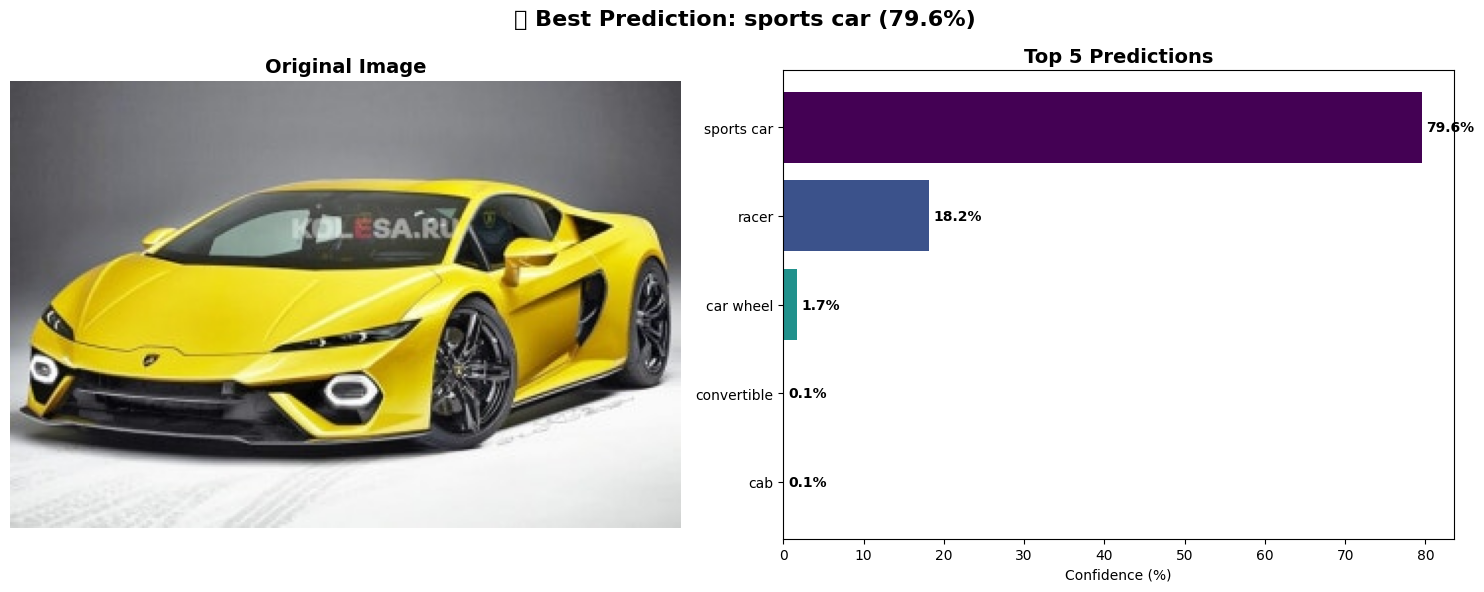


📊 모델 정보:
   🧠 모델: ResNet
   💻 디바이스: cuda
   📋 총 클래스 수: 1000

✅ ImageNet 분류 완료!


{'original_image': <PIL.Image.Image image mode=RGB size=340x227>,
 'predictions': [{'rank': 1,
   'class_index': 817,
   'class_name': 'sports car',
   'probability': 0.7956271171569824,
   'percentage': 79.56271171569824},
  {'rank': 2,
   'class_index': 751,
   'class_name': 'racer',
   'probability': 0.18212443590164185,
   'percentage': 18.212443590164185},
  {'rank': 3,
   'class_index': 479,
   'class_name': 'car wheel',
   'probability': 0.017048748210072517,
   'percentage': 1.7048748210072517},
  {'rank': 4,
   'class_index': 511,
   'class_name': 'convertible',
   'probability': 0.0010395777644589543,
   'percentage': 0.10395777644589543},
  {'rank': 5,
   'class_index': 468,
   'class_name': 'cab',
   'probability': 0.0010053502628579736,
   'percentage': 0.10053502628579736},
  {'rank': 6,
   'class_index': 705,
   'class_name': 'passenger car',
   'probability': 0.0010017927270382643,
   'percentage': 0.10017927270382643},
  {'rank': 7,
   'class_index': 436,
   'class_nam

In [5]:
# 📦 Google Colab용 ImageNet 1000개 클래스 분류기
# 🧠 사전 훈련된 딥러닝 모델로 즉시 객체 인식!

# 필요한 라이브러리 설치 및 임포트
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from io import BytesIO
import cv2

print("✅ 라이브러리 로드 완료!")
print(f"🔥 PyTorch 버전: {torch.__version__}")
print(f"💻 CUDA 사용 가능: {torch.cuda.is_available()}")

# =============================================================================
# ImageNet 1000개 클래스 분류기
# =============================================================================

class ImageNetClassifier:
    """ImageNet 사전 훈련된 모델을 사용한 1000개 클래스 분류기"""

    def __init__(self, model_name='resnet50'):
        print(f"🧠 {model_name} 모델 로딩 중...")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"💻 사용 디바이스: {self.device}")

        # 모델 로드
        self.model = self.load_model(model_name)
        self.model.eval()  # 평가 모드

        # ImageNet 클래스 라벨 로드
        self.class_labels = self.load_imagenet_labels()

        # 이미지 전처리 설정
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        print(f"✅ {model_name} 모델 준비 완료!")
        print(f"📊 분류 가능한 클래스: 1000개")

    def load_model(self, model_name):
        """사전 훈련된 모델 로드"""
        models_dict = {
            'resnet50': models.resnet50(pretrained=True),
            'resnet101': models.resnet101(pretrained=True),
            'vgg16': models.vgg16(pretrained=True),
            'vgg19': models.vgg19(pretrained=True),
            'densenet121': models.densenet121(pretrained=True),
            'efficientnet_b0': models.efficientnet_b0(pretrained=True),
            'mobilenet_v2': models.mobilenet_v2(pretrained=True),
            'alexnet': models.alexnet(pretrained=True),
            'inception_v3': models.inception_v3(pretrained=True)
        }

        if model_name not in models_dict:
            print(f"⚠️ {model_name} 모델을 찾을 수 없습니다. ResNet50을 사용합니다.")
            model_name = 'resnet50'

        model = models_dict[model_name]
        return model.to(self.device)

    def load_imagenet_labels(self):
        """ImageNet 1000개 클래스 라벨 로드"""
        try:
            # ImageNet 클래스 라벨 다운로드
            url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
            response = requests.get(url)
            labels = response.text.strip().split('\n')
            print(f"📋 ImageNet 라벨 로드 완료: {len(labels)}개")
            return labels
        except:
            print("⚠️ 온라인 라벨 로드 실패. 기본 라벨을 사용합니다.")
            # 일부 주요 클래스만 포함한 기본 라벨
            return [f"class_{i}" for i in range(1000)]

    def load_image(self, image_source):
        """이미지 로드 (파일 경로 또는 URL)"""
        try:
            if isinstance(image_source, str):
                if image_source.startswith('http'):
                    # URL에서 이미지 다운로드
                    response = requests.get(image_source)
                    image = Image.open(BytesIO(response.content)).convert('RGB')
                else:
                    # 로컬 파일
                    image = Image.open(image_source).convert('RGB')
            else:
                # PIL Image 객체
                image = image_source.convert('RGB')

            return image
        except Exception as e:
            print(f"❌ 이미지 로드 실패: {e}")
            return None

    def preprocess_image(self, image):
        """이미지 전처리"""
        if image is None:
            return None

        # PIL Image → Tensor
        tensor = self.transform(image).unsqueeze(0)  # 배치 차원 추가
        return tensor.to(self.device)

    def predict(self, image_source, top_k=5):
        """이미지 분류 예측"""
        print(f"🔍 이미지 분석 중...")

        # 이미지 로드
        image = self.load_image(image_source)
        if image is None:
            return None

        original_image = image.copy()

        # 전처리
        input_tensor = self.preprocess_image(image)
        if input_tensor is None:
            return None

        # 예측
        with torch.no_grad():
            outputs = self.model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)

        # Top-K 결과 추출
        top_prob, top_indices = torch.topk(probabilities, top_k)

        results = []
        for i in range(top_k):
            class_idx = top_indices[i].item()
            prob = top_prob[i].item()
            class_name = self.class_labels[class_idx]
            results.append({
                'rank': i + 1,
                'class_index': class_idx,
                'class_name': class_name,
                'probability': prob,
                'percentage': prob * 100
            })

        return {
            'original_image': original_image,
            'predictions': results,
            'model_info': {
                'model_name': self.model.__class__.__name__,
                'device': str(self.device),
                'total_classes': len(self.class_labels)
            }
        }

    def visualize_results(self, results, show_top_k=5):
        """결과 시각화"""
        if results is None:
            print("❌ 결과가 없습니다.")
            return

        # 결과 출력
        print(f"\n🎯 ImageNet 분류 결과 (Top {show_top_k}):")
        print("=" * 60)

        predictions = results['predictions'][:show_top_k]

        for pred in predictions:
            print(f"{pred['rank']}. {pred['class_name']:<30} {pred['percentage']:.2f}%")

        print("=" * 60)

        # 시각화
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # 원본 이미지
        ax1.imshow(results['original_image'])
        ax1.set_title('Original Image', fontsize=14, fontweight='bold')
        ax1.axis('off')

        # 예측 결과 막대 그래프
        class_names = [pred['class_name'][:20] for pred in predictions]  # 이름 길이 제한
        probabilities = [pred['percentage'] for pred in predictions]
        colors = plt.cm.viridis(np.linspace(0, 1, len(predictions)))

        bars = ax2.barh(range(len(predictions)), probabilities, color=colors)
        ax2.set_yticks(range(len(predictions)))
        ax2.set_yticklabels(class_names)
        ax2.set_xlabel('Confidence (%)')
        ax2.set_title(f'Top {show_top_k} Predictions', fontsize=14, fontweight='bold')
        ax2.invert_yaxis()  # 높은 확률이 위로

        # 막대에 퍼센트 표시
        for i, (bar, prob) in enumerate(zip(bars, probabilities)):
            ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{prob:.1f}%', va='center', fontweight='bold')

        # 전체 제목
        best_prediction = predictions[0]
        plt.suptitle(f'🏆 Best Prediction: {best_prediction["class_name"]} ({best_prediction["percentage"]:.1f}%)',
                    fontsize=16, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # 모델 정보
        model_info = results['model_info']
        print(f"\n📊 모델 정보:")
        print(f"   🧠 모델: {model_info['model_name']}")
        print(f"   💻 디바이스: {model_info['device']}")
        print(f"   📋 총 클래스 수: {model_info['total_classes']}")

    def compare_models(self, image_source, model_names=['resnet50', 'vgg16', 'efficientnet_b0']):
        """여러 모델 성능 비교"""
        print(f"🔄 다중 모델 비교 시작...")

        original_model = self.model
        original_name = original_model.__class__.__name__

        results_comparison = []

        for model_name in model_names:
            print(f"\n🧠 {model_name} 모델로 예측 중...")

            # 모델 변경
            self.model = self.load_model(model_name)
            self.model.eval()

            # 예측
            result = self.predict(image_source, top_k=3)
            if result:
                best_pred = result['predictions'][0]
                results_comparison.append({
                    'model_name': model_name,
                    'best_class': best_pred['class_name'],
                    'confidence': best_pred['percentage'],
                    'top3': result['predictions']
                })

        # 원래 모델 복원
        self.model = original_model

        # 비교 결과 시각화
        if results_comparison:
            self.visualize_model_comparison(results_comparison, image_source)

        return results_comparison

    def visualize_model_comparison(self, results_comparison, image_source):
        """모델 비교 결과 시각화"""
        # 이미지 로드
        image = self.load_image(image_source)

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 원본 이미지
        axes[0, 0].imshow(image)
        axes[0, 0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0, 0].axis('off')

        # 각 모델별 Top 1 결과
        model_names = [result['model_name'] for result in results_comparison]
        confidences = [result['confidence'] for result in results_comparison]
        predictions = [result['best_class'][:15] for result in results_comparison]  # 이름 단축

        colors = ['red', 'blue', 'green', 'orange', 'purple'][:len(model_names)]

        bars = axes[0, 1].bar(model_names, confidences, color=colors, alpha=0.7)
        axes[0, 1].set_title('Model Confidence Comparison', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('Confidence (%)')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # 막대에 예측 클래스와 확률 표시
        for bar, pred, conf in zip(bars, predictions, confidences):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                           f'{pred}\n{conf:.1f}%', ha='center', va='bottom', fontsize=10)

        # 상세 비교 테이블
        axes[1, 0].axis('off')
        table_data = []
        for result in results_comparison:
            row = [result['model_name'], result['best_class'][:20], f"{result['confidence']:.1f}%"]
            table_data.append(row)

        table = axes[1, 0].table(cellText=table_data,
                                colLabels=['Model', 'Best Prediction', 'Confidence'],
                                cellLoc='center',
                                loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        axes[1, 0].set_title('Detailed Comparison', fontsize=14, fontweight='bold')

        # 모델별 Top 3 비교
        axes[1, 1].axis('off')
        y_pos = 0.9
        for result in results_comparison:
            axes[1, 1].text(0.05, y_pos, f"🧠 {result['model_name']}:", fontweight='bold', fontsize=12)
            y_pos -= 0.08
            for i, pred in enumerate(result['top3']):
                axes[1, 1].text(0.1, y_pos, f"{i+1}. {pred['class_name'][:25]} ({pred['percentage']:.1f}%)",
                               fontsize=10)
                y_pos -= 0.06
            y_pos -= 0.02

        axes[1, 1].set_xlim(0, 1)
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].set_title('Top 3 Predictions per Model', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

# =============================================================================
# 실행 함수들
# =============================================================================

def classify_uploaded_image():
    """파일 업로드 후 ImageNet 분류"""
    print("🚀 ImageNet 1000개 클래스 분류기 시작!")
    print("=" * 60)

    # 파일 업로드
    print("📁 이미지를 업로드해주세요...")
    print("🎯 1000개 클래스 중에서 가장 유사한 객체를 찾아드립니다!")

    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("❌ 파일이 업로드되지 않았습니다!")
        return None

    filename = list(uploaded.keys())[0]
    print(f"📷 업로드된 파일: {filename}")

    try:
        # 분류기 생성
        classifier = ImageNetClassifier(model_name='resnet50')

        # 예측
        results = classifier.predict(filename, top_k=10)

        # 결과 시각화
        classifier.visualize_results(results, show_top_k=5)

        print("\n✅ ImageNet 분류 완료!")
        return results

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

def compare_multiple_models():
    """여러 모델로 동일 이미지 비교"""
    print("🔄 다중 모델 성능 비교!")
    print("=" * 60)

    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("❌ 파일이 업로드되지 않았습니다!")
        return None

    filename = list(uploaded.keys())[0]
    print(f"📷 업로드된 파일: {filename}")

    try:
        # 분류기 생성
        classifier = ImageNetClassifier()

        # 여러 모델 비교
        models_to_compare = ['resnet50', 'vgg16', 'efficientnet_b0', 'mobilenet_v2']
        comparison_results = classifier.compare_models(filename, models_to_compare)

        print("\n✅ 다중 모델 비교 완료!")
        return comparison_results

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

def batch_classify():
    """여러 이미지 일괄 업로드 분류"""
    print("📁 여러 이미지 일괄 분류!")
    print("=" * 60)

    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("❌ 파일이 업로드되지 않았습니다!")
        return None

    try:
        classifier = ImageNetClassifier()
        results_list = []

        for filename in uploaded.keys():
            print(f"\n🔍 {filename} 분석 중...")
            results = classifier.predict(filename, top_k=5)

            if results:
                # 간단한 결과 출력
                best_pred = results['predictions'][0]
                print(f"🏆 {filename}: {best_pred['class_name']} ({best_pred['percentage']:.1f}%)")
                results_list.append((filename, best_pred['class_name'], best_pred['percentage']))

        # 전체 결과 요약
        print(f"\n{'='*60}")
        print("📋 일괄 분류 결과 요약")
        print(f"{'='*60}")
        for filename, pred_class, confidence in results_list:
            print(f"📷 {filename:25} → {pred_class:20} ({confidence:.1f}%)")

        return results_list

    except Exception as e:
        print(f"❌ 오류 발생: {e}")
        return None

# =============================================================================
# 메인 실행 부분
# =============================================================================

print("🎯 ImageNet 1000개 클래스 분류기 실행 옵션:")
print("1. 단일 이미지 분류: classify_uploaded_image()")
print("2. 다중 모델 비교: compare_multiple_models()")
print("3. 여러 이미지 일괄 분류: batch_classify()")
print("\n💡 추천: classify_uploaded_image() 로 시작하세요!")
print("\n🧠 사용 가능한 모델: ResNet50, VGG16, EfficientNet, MobileNet 등")
print("📊 분류 가능: 동물, 차량, 음식, 도구, 자연물 등 1000개 카테고리")
print("\n⚡ 준비 완료! 업로드 전용 ImageNet 분류기입니다!")

# 사용자가 직접 함수 호출
classify_uploaded_image()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

100%|██████████| 6.25M/6.25M [00:00<00:00, 155MB/s]


YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco8.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patienc

100%|██████████| 433k/433k [00:00<00:00, 28.2MB/s]
Unzipping /content/datasets/coco8.zip to /content/datasets/coco8...: 100%|██████████| 25/25 [00:00<00:00, 3613.54file/s]

Dataset download success ✅ (0.4s), saved to /content/datasets




100%|██████████| 755k/755k [00:00<00:00, 41.1MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

Model summary: 129 layers, 3,157,200 parameters, 3,157,184 gradients, 8.9 GFLOPs

Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 160MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 875.5±269.7 MB/s, size: 50.0 KB)


train: Scanning /content/datasets/coco8/labels/train... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 997.99it/s]

train: New cache created: /content/datasets/coco8/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 637.3±528.5 MB/s, size: 54.0 KB)


val: Scanning /content/datasets/coco8/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 1184.33it/s]

val: New cache created: /content/datasets/coco8/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.619G     0.9689      2.167      1.332         13        640: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]

                   all          4         17      0.616      0.875      0.888      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/10      0.65G      1.057      2.664      1.362         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]

                   all          4         17      0.593      0.897      0.888       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.654G     0.9198      1.931      1.208         13        640: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.48it/s]

                   all          4         17      0.598      0.882      0.888      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.662G      0.984      2.543      1.327         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]

                   all          4         17      0.551      0.838      0.874      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.666G      1.063      2.402      1.361         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.13it/s]

                   all          4         17      0.619      0.833      0.874      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.674G     0.9205      2.671      1.382         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.35it/s]

                   all          4         17      0.681      0.833       0.88      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.711G      1.248      2.765      1.389         13        640: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


                   all          4         17      0.717       0.75      0.893      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      0.73G      1.039      2.115      1.366         13        640: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.65it/s]

                   all          4         17      0.681       0.75      0.893       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.748G     0.8688      1.565      1.135         13        640: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.37it/s]

                   all          4         17      0.663       0.75      0.884      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.766G     0.9463      1.978      1.347         13        640: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


                   all          4         17      0.703       0.75      0.812      0.602

10 epochs completed in 0.002 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


                   all          4         17      0.717       0.75      0.892      0.622
                person          3         10      0.664        0.5      0.546      0.299
                   dog          1          1       0.58          1      0.995      0.697
                 horse          1          2      0.689          1      0.995      0.648
              elephant          1          2          1          0      0.828      0.197
              umbrella          1          1      0.567          1      0.995      0.995
          potted plant          1          1      0.799          1      0.995      0.895
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


Saving traffic.jpg to traffic.jpg

image 1/1 /content/traffic.jpg: 448x640 8 cars, 42.1ms
Speed: 2.5ms preprocess, 42.1ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


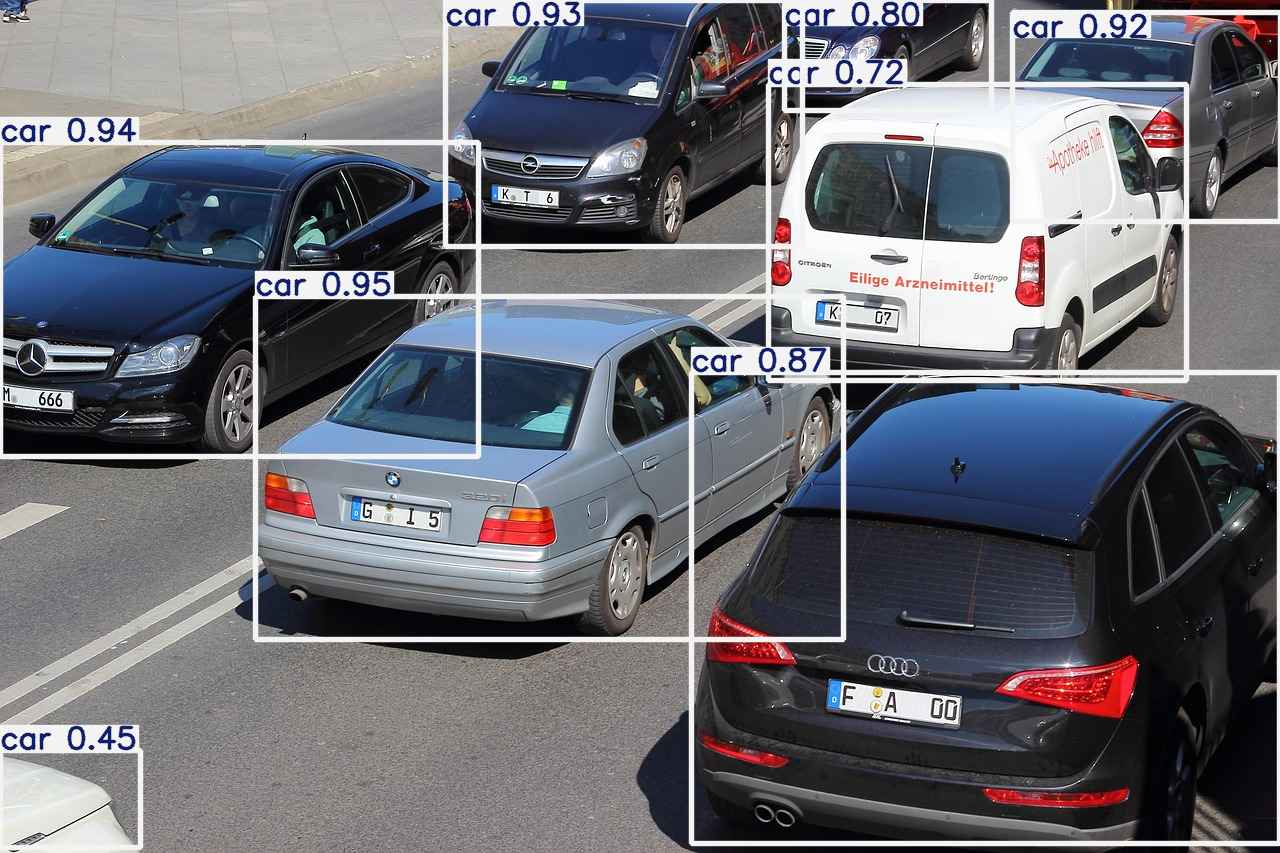

In [1]:
!pip install ultralytics
from google.colab import files
from ultralytics import YOLO # COCO 사전 훈련된 YOLOv8n 모델 로드
model = YOLO("yolov8n.pt") # 모델 정보 표시 (선택사항)
model.info() # COCO8 예제 데이터셋으로 100 에포크 훈련
results = model.train(data="coco8.yaml", epochs=10, imgsz=640) # 사진 업로드하고 경로 설정
uploaded = files.upload()
image_path = list(uploaded.keys())[0] # 업로드한 이미지에 대해 YOLOv8n 모델로 추론 실행
results = model(image_path)
results[0].show()